# AWS Data Processing
This Jupyter notebook contains code to process AWS data to a standardized format for the PyGEM-EB model. Any data that is not passed from the AWS will be grabbed from the ERA5-hourly dataset. Note that this code may not be comprehensive for all errors that arise from the formatting of a specific dataset.

In [25]:
import numpy as np
import os
import xarray as xr
import logging
import pandas as pd
import matplotlib.pyplot as plt
debug = True

## 0. Define variables
Fill out the cell below to set up the glacier being accessed and the filepaths.

In [ ]:
glac_no = ['01.00570']          # RGI Glacier ID
station = 'gulkana1725'         # You choose: descriptive name for log and output
elev = 1725                     # Elevation of AWS in m a.s.l.
data_fn = 'Gulkana/LVL2/gulkana1725_hourly_LVL2.csv'    # File name of data

In [24]:
# Storglaciaren: 08.00213, Gulkana: 01.00570, Artesonraju: 16.02444, Saint-Sorlin: 11.03674, South: 01.16195
# GLACIER STUFF
glac_no = ['01.16195']          # RGI Glacier ID
station = 'south2280'           # You choose: descriptive name for log and output
elev = 2280                     # Elevation of AWS in m a.s.l.

# USER SPECIFIED
data_min_percentage = 0.5       # Below this threshold, data will be thrown out and filled from the GCM rather than interpolated

# FILEPATHS
fp = '/home/claire/research/climate_data/AWS/'          # Filepath to data
data_fn = 'Raw/southglacier.csv'    # File name of data
# data_fn = 'SaintSorlin/SaintSorlin_hourly.csv'
gcm_fp = '/home/claire/research/CDS/'                   # Filepath to GCM data used to fill holes
attr_fp = '/home/claire/research/RGI/rgi60/00_rgi60_attribs/'        # Filepath to RGI data
export_fn = fp+'Preprocessed/'+station+'_hourly.csv'
# 'Storglaciaren/SITES_MET_TRS_SGL_20130417-20130912_15MIN.csv'
# 'Artesonraju/data_aws_peru.csv'

## 1. Load Data
From the output of the first cell, make sure the columns have been properly loaded. The cell below contains a dictionary with possible names for each actual variable name. If the column names printed are missing, add those here, and update the name for the time variable.

If the data is sub-hourly, resampling requires the variable name for precipitation to be explicitly stated in 'precip_vn'.

In [26]:
# Read in the data and make sure the columns were correctly loaded
# NOTE this step is likely to cause errors that can be fixed by adjusting the input arguments, for example delim_whitespace
rows_to_skip = 0     # Number of rows that contain text at the beginning of the file (34 for Storglaciaren)
df = pd.read_csv(fp + data_fn,skiprows=rows_to_skip,delim_whitespace=False)
print(df.columns.to_numpy())

['TIMESTAMP' 'wind' 'winddir' 'temp' 'rh' 'SWout' 'SWin' 'LWout' 'LWin'
 'sp']


In [27]:
# Fill out after executing above to check the variable names for time and precipitation
time_vn = 'TIMESTAMP' 
names = {'temp':['site_temp_USGS','temperature','Tair_aws','temp','TA_2.0m','T'],
            'tp':['Precip_Weighing_Incremental','precipitation','Ptotal_aws','tp','P'],
            'rh':['RelHum','RH','rh','rH','RH_aws','RH_2.0m'],
            'SWin':['RadiationIn','SWin','SWin_aws','SW_IN'],
            'SWout':['RadiationOut','SWout','SWout_aws','SW_out','SW_OUT'],
            'LWin':['LWRadiationIn','LWin','LWin_aws','LW_in','LW_IN'],
            'LWout':['LWRadiationOut','LWout','LWout_aws','LW_OUT'],
            'wind':['WindSpeed','wind','Wind','ws_aws','WS'],
            'winddir':['VecAvgWindDir','WindDir','Winddir','winddir','WD'],
            'sp':['barom','sp','press','Press_aws','Barom'],
            'tcc':['cloud_fraction','tcc','CCF','CCF_aws']}

precip_vn = 'P'     # This line can be skipped if the data is already hourly

In [28]:
# Space for extra preprocessing if opening the file isn't enough:
# n = len(df['TIMESTAMP'])
# store = []
# for i in range(n):
#     datetime = str(df.index[i]) +' '+ df['TIMESTAMP'][i]
#     store.append(datetime)
# df['TIMESTAMP'] = store

## 2. Launch logger
The logger stores information regarding the process and is saved alongside the final output .csv.

In [29]:
logger = logging.getLogger()
fhandler = logging.FileHandler(filename = export_fn.replace('csv','log'))
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

# Check
today = str(pd.Timestamp.today()).replace('-','_')[0:10]
logger.info(f'Data for {station} prepared on {today}')

## 3. Resample to hourly
Add the time index to the dataframe. If the original data has a sub-hourly frequency, resample by taking averages of each variable, with the exception of precipitation which is summed.

In [30]:
# Set time as the dataframe index and remove the time column
data_start = pd.to_datetime(df[time_vn][0])
data_end = pd.to_datetime(df[time_vn].to_numpy()[-1])
freq = pd.to_datetime(df[time_vn][1]) - data_start
print(f'Data extends from {data_start} to {data_end} with frequency {freq.seconds / 60} min')
df = df.set_index(pd.date_range(data_start,data_end,freq=str(round(freq.seconds/60))+'T'))
df = df.drop(time_vn,axis=1)
ntimesteps = np.shape(pd.date_range(data_start,data_end,freq='H'))[0]

# Resample hourly
if freq.seconds / 3600 < 1:
    # df[precip_vn] = df[precip_vn].resample('H').sum()
    cols_noP = np.delete(df.columns.to_numpy(),np.where(df.columns.to_numpy()=='P'))
    df[cols_noP] = df[cols_noP].resample('H').mean()
    df = df.loc[pd.date_range(data_start,data_end,freq='H')]

Data extends from 2006-07-09 15:00:00 to 2015-08-27 08:00:00 with frequency 60.0 min


## 4. Rename variables
The following code should rename inconsistent naming to that used in PyGEM-EB. It will print any variable names that were passed from the original file but were not renamed. Check this list to make sure this list doesn't contain any data you need, as it will be removed in the next step.

! If this list contains a data variable you need, the printed name was not included in the list of possible options. Uncomment the block of code labeled 'UPDATE NAMES', add the corresponding variable names, and rerun the renaming block. (Or manually add these names to the 'names' variable above.)

In [31]:
# RENAMING
drop_vars = []
all_vars = ['temp','tp','rh','SWin','SWout','LWin','LWout','wind','winddir','sp','tcc']
for var in df.columns.to_numpy():
    renamed = False
    for var_check in all_vars:
        if var in names[var_check]:
            df = df.rename(columns={var:var_check})
            all_vars.remove(var_check)
            renamed = True
    if not renamed:
        drop_vars.append(var)
if len(drop_vars) > 0:
    print('Variables were not renamed, including:')
    print(drop_vars)
else:
    drop_vars = [0]

In [32]:
# UPDATE NAMES
# var_to_fill = 'LWin'
# new_name = 'LW_IN'
# names[var_to_fill].append(new_name)

## 5. Fill data gaps (GCM or interpolation)
Several variables are hard requirements for the model to run: temperature, precipitation, RH, wind speed, shortwave radiation, barometric pressure and cloud cover fraction. Check which are missing and fill them from ERA5-hourly data. Then fill the remainder of data by interpolation. The default method uses cubic spline interpolation, but this can be easily edited in the df.interpolate() command.

In [48]:
def getERA5Coords(glac_no):
    """
    Gets the ERA5-Land cell coordinates of the cell where the glacier lies.
    
    Parameters
    ----------
    glac_no : str
        RGI glacier ID
    """
    region = glac_no[:2]

    # Open RGI attributes file for the region
    for fn in os.listdir(attr_fp):
        if region in fn and 'Zone' not in fn:
            attr_df = pd.read_csv(attr_fp+fn,encoding='unicode_escape')
    attr_df['RGIId'] = [str(attr_df['RGIId'].values[i])[6:] for i in range(len(attr_df.index))]
    attr_df = attr_df.set_index('RGIId')

    cenlat = attr_df['CenLat'].loc[glac_no]
    cenlon = attr_df['CenLon'].loc[glac_no]

    example_fp = f'~/research/CDS/GCMexample.nc'
    data = xr.open_dataset(example_fp)
    datalat = data.coords['latitude'][:].values
    datalon = data.coords['longitude'][:].values - 180
    lat_nearidx = np.abs(cenlat - datalat).argmin(axis=0)
    lon_nearidx = np.abs(cenlon - datalon).argmin(axis=0)

    lat = data.coords['latitude'][lat_nearidx].values - 0
    lon = data.coords['longitude'][lon_nearidx].values - 180

    return [lat,lon]

In [53]:
var = 'precip'
data_fp = f'/home/claire/research/climate_data/ERA5/ERA5_hourly/ERA5_{var}_hourly.nc'
cell_coords = getERA5Coords(glac_no[0])

# def getERA5Data(df,var,cell_coords):
# Get years of data and names of variables to extract data
data_years = np.arange(data_start.year,data_end.year+1)
var_dict = {'temp':'2m_temperature','precip':'total_precipitation','wind':'10m_u_component_of_wind',
            'sp':'surface_pressure','SWin':'surface_shortwave_radiation_downwards','dtemp':'2m_dewpoint_temperature','tcc':'total_cloud_cover'}
var_ln = var_dict[var]
lat,lon = cell_coords

# Create loop to handle the special case of wind -- other variables only loop once
nloops = 1
loop = 0
while loop < nloops:
    # Loop through years and concatenate data from start to end date
    for year in data_years:
        fp = data_fp.replace('year',str(year)).replace('var',var_ln)
        da = xr.open_dataarray(data_fp)
        da = da.sel(latitude=lat,longitude=lon)
        if year == data_years[0]:
            var_da = da
            var_da = var_da.loc[np.datetime64(data_start):]
        elif year == data_years[-1]:
            var_da = var_da.concat(da.loc[:np.datetime64(data_end)],'time')
        else:
            var_da = var_da.concat(da,'time')
    if var in ['wind','winddir']:
        nloops = 2
        var_da_uwind = var_da
        var_ln = '10m_v_component_of_wind'
    loops += 1

if var in ['wind','winddir']:
    wind = np.sqrt(var_da_uwind.values**2 + var_da.values**2)
    winddir = np.arctan2(-var_da_uwind.values,-var_da.values) * 180 / np.pi
    df['wind'] = wind
    df['winddir'] = winddir
else:
    df[var] = var_da
    # return df

KeyError: "not all values found in index 'latitude'. Try setting the `method` keyword argument (example: method='nearest')."

In [52]:
def fill_and_remove_variables(df,ERA5_cell,drop_vars=[0]):
    """
    Drops any variables which are unnecessary, passed by drop_vars, and checks if each necessary
    variable is there. If not, the variable is filled from ERA5-hourly.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing AWS data
    drop_vars : list
        List of names of variables to drop
    ERA5_cell : list-like
        List of (lat,lon) values for the ERA5-Land cell where the glacier lies
    """
    vars = df.columns.to_numpy()
    nans = np.zeros(ntimesteps)
    nans[:] = np.nan

    # Add any specific revisions that need to be made between data columns. 
    # For example if there are two precip sensors, active at different times, merge the data.
    if 'Precip_Stage_Incremental' in vars:
        df.tp.fillna(df.Precip_Stage_Incremental*1.48, inplace=True)
    
    # Drop the variables that don't contain relevant data
    if drop_vars[0] in vars:
        df = df.drop(drop_vars,axis=1)

    # Log which variables will be filled with GCM data
    all_vars = ['temp','tp','rh','SWin','wind','winddir','tcc','sp']
    fill_vars = []
    for var in all_vars:
        if var not in vars:
            logger.info(f'Variable {var} not in data; filling from ERA5')

            # getERA5data(var)

            # # Set filepath for the lat, lon and variable
            # if glac_no == ['01.00570']:
            #     var_fp = f'/home/claire/research/climate_data/ERA5/ERA5_hourly/ERA5_{var}_hourly.nc'
            # else:
            #     var_fp = gcm_fp + f'ERA5_{var}_{lat:.0f}_{lon:.0f}_hourly.nc'

            # # RH handled using dewpoint temperature
            # if var == 'rh':
            #     var = 'dtemp'
            #     var_fp = var_fp.replace('rh','dtemp')

            # # Check if ERA5 data exists for the variable, lat and lon
            # if not os.path.exists(var_fp):
            #     logger.error(f'ERA5 hourly {var} datafile does not exist for {ERA5_cell}, download necessary')
            #     fill_vars.append(var)
            # else:
            #     da = xr.open_dataarray(var_fp)
            #     df[var] = da.loc[np.datetime64(data_start):np.datetime64(data_end)].values[:,0,0]
    
    # Some variables are not necessary, but still must exist as NaNs
    unnecessary_vars = ['SWout','LWin','LWout','winddir']
    for var in unnecessary_vars:
        if var not in df.columns.to_numpy():
            df[var] = nans
    # Need EITHER rh or dtemp
    if 'dtemp' not in df.columns.to_numpy():
        df['dtemp'] = nans
    if 'rh' not in df.columns.to_numpy():
        df['rh'] = nans
    return df, fill_vars

In [20]:
cell_coords = getERA5Coords(glac_no[0])
df,_ = fill_and_remove_variables(df,cell_coords,drop_vars)
vars = df.columns.to_numpy()
redo_fill = False
# For each variable, check how much data is there and fill by interpolation or GCM
for var in vars:
    n_NaN = ntimesteps - df[var].count()
    if n_NaN > 0 and n_NaN <= ntimesteps * data_min_percentage: # if at least x% of data is there
        logger.info(f'Variable {var} missing {n_NaN} values; filling by linear interpolation')
    elif n_NaN > ntimesteps * data_min_percentage and n_NaN < ntimesteps: # less than x% is there; slash it and take from GCM
        logger.info(f'Variable {var} missing a majority of values; filling from ERA5')
        df.drop(var,axis=1)
        redo_fill = True
if redo_fill:
    df,_ = fill_and_remove_variables(df,cell_coords)
df = df.interpolate('linear')

## 6. Check for remaining data gaps
Check the data count to look for big data gaps that weren't filled by interpolation. This likely indicates the sensor was down for a period or wasn't installed until some time into the date range. 

In [21]:
for var in df.columns.to_numpy():
    if df[var].count() < ntimesteps and df[var].count() > 0:
        nmissing = ntimesteps - df[var].count()
        missing = df['LWin'][df['LWin'].isna()]
        start_missing = str(missing.index[0])[0:10]
        end_missing = str(missing.index[-1])[0:10]
        logger.info(f'Variable {var} is still missing {nmissing} values between {start_missing} and {end_missing}')

## 7. Check units
Check the units of each variable. Since the input file may not specify them, this check is done by reasonable range of values for common mistakes (Celsius/Kelvin, percent/decimal, degrees/radians). This will catch major errors, but if there is uncertainty about the data units, double check the data source and update this code as necessary!

In [22]:
units = {'temp':'C','dtemp':'K','tp':'m','rh':'%',
        'SWin':'J m-2','SWout':'J m-2','LWin':'J m-2','LWout':'J m-2',
        'tcc':'0-1','wind':'m s-1','winddir':'deg','sp':'Pa'}
if df['temp'].min() > 0:                # implies data in Kelvin
    df['temp'] = df['temp'] - 273.15
if df['rh'].max() < 1:                  # implies data in decimal
    df['rh'] = df['rh'] * 100
if df['winddir'].max() < 4:             # implies data in Radians
    df['winddir'] = df['winddir'] * 180/np.pi
if df['tcc'].min() > 1:                 # implies data in percentage; need in decimal
    df['tcc'] = df['tcc'] / 100
if df['tp'].max() > 1:
    df['tp'] = df['tp'] / 1000

# Additional corrections
df['sp'] = df['sp'] * 1

KeyError: 'tcc'

## 8. Final check and export
Print the dataframe one last time to make sure it looks right. There should be 12 columns total. Then export it!

In [ ]:
df['z'] = elev
print(df)

                     temp   tp  wind   SWin  SWout  winddir       dtemp  \
2013-03-19 17:00:00 -24.1  NaN   5.5    0.0    0.0      NaN  246.094437   
2013-03-19 18:00:00 -24.1  NaN   6.5    0.0    0.1      NaN  247.756287   
2013-03-19 19:00:00 -24.2  NaN   7.5    0.0    0.1      NaN  248.400879   
2013-03-19 20:00:00 -23.8  NaN  10.7    0.0    0.1      NaN  248.717590   
2013-03-19 21:00:00 -23.6  NaN  10.6    0.0    0.0      NaN  249.403488   
...                   ...  ...   ...    ...    ...      ...         ...   
2019-04-27 05:00:00  -6.9  0.0   2.0    1.6    1.6    322.0  258.507080   
2019-04-27 06:00:00  -7.0  0.0   2.6   18.5   14.1    328.0  259.367676   
2019-04-27 07:00:00  -5.6  0.0   1.1  172.5  113.7    354.0  259.938263   
2019-04-27 08:00:00  -3.8  0.0   0.4  301.7  197.8     71.0  260.324677   
2019-04-27 09:00:00  -2.8  0.0   0.4  432.7  283.9     71.0  260.055328   

                          tcc            sp  LWin  LWout  rh     z  
2013-03-19 17:00:00  0.815284 

In [ ]:
df.to_csv(export_fn)

In [ ]:
#################################################################

In [ ]:
plt.plot(df.index,np.cumsum(df['tp']))

NameError: name 'df' is not defined

## 9. (Optional) Calibrate precipitation multiplier (kp)
Precipitation data is typically poor quality, especially during the accumulation season, so a multiplication factor is required to get reasonable amounts of snowfall. For this, winter mass balance data over the years of the AWS data is required. Specify this data filepath below.

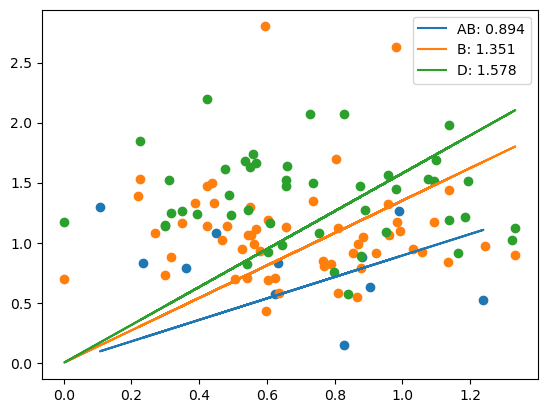

In [23]:
# Load in mass balance and weather data (using daily weather)
mb_filepath = '~/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'
weather_filepath = '~/research/MB_data/Gulkana/Input_Gulkana_Daily_Weather.csv'
mbdf = pd.read_csv(mb_filepath,index_col='site_name')
weatherdf = pd.read_csv(weather_filepath,index_col='Date')
sites = np.unique(mbdf.index)

# Set time index for weather dataframe
weatherstart = pd.to_datetime(weatherdf.index[0])
weatherend = pd.to_datetime(weatherdf.index.to_numpy()[-1])
weatherdf = weatherdf.set_index(pd.date_range(weatherstart,weatherend,freq='D'))

for site in ['AB','B','D']:
    # Extract site mass balance data
    site_df = mbdf.loc[site].set_index('Year')
    site_bw = site_df['bw'] - site_df['winter_ablation'].fillna(0)

    # Check if site mass balance data exists in a smaller range than the weather data
    if weatherstart.year < site_df.index[0]:
        startyr = site_df.index[0]
    else:
        startyr = weatherstart.year
    if weatherend.year > site_df.index[site_df.shape[0]-1]:
        endyr = site_df.index[site_df.shape[0]-1]
    else:
        endyr = weatherend.year
    years = np.arange(startyr,endyr)

    # Adjust temperature to the site
    site_elev = np.mean(site_df['elevation'])
    site_temp = weatherdf['Temperature'] + 0.0065*(elev-site_elev)

    # Build the annual precipitation sums
    precip_yearly = []
    for year in years:
        # Get first day where the temperature is below freezing
        for day in site_temp.index:
            if site_temp.loc[day] < 0 and day.month > 6 and day.year == year:
                break
        season_start = day
        season_end = pd.to_datetime(site_df['spring_date'].loc[year+1])

        # Sum precipitation between the first snowfall and snowpit measurement
        precip_sum = np.sum(weatherdf['Precipitation'].loc[season_start:season_end]) / 1000
        precip_yearly.append(precip_sum)

    # Regress for slope to best match precip data to accumulation
    X = np.array(precip_yearly[1:]).reshape(-1,1)
    y = site_bw.loc[years[1]:years[-1]].to_numpy()
    kp,res,_,_ = np.linalg.lstsq(X,y,rcond=None)
    # print(1-res/np.sum(np.square(y-np.mean(y))))

    plt.plot(X,X*kp,label=f'{site}: {kp[0]:.3f}')
    plt.scatter(X,y)
    plt.legend()
    
# optimize to get kp which matches winter accumulation to winter MB

In [ ]:
 # Storglaciaren: 08.00213, Gulkana: 01.00570, Artesonraju: 16.02444
if glac_no in ['01.00570']:
    lat = [63.34]
    lon = [-145.5]
elif glac_no in ['08.00213']:
    lat = [67.88]
    lon = [18.56]
elif glac_no in ['16.02444']:
    lat = [-8.95]
    lon = [-77.63]

In [ ]:
ds = xr.open_dataset(fp+'/../../ERA5/ERA5_hourly/ERA5_temp_hourly.nc')
print(ds)

<xarray.Dataset>
Dimensions:    (longitude: 1, latitude: 1, time: 368184)
Coordinates:
  * longitude  (longitude) float32 -145.5
  * latitude   (latitude) float32 63.34
  * time       (time) datetime64[ns] 1980-01-01 ... 2021-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    units:      K
    long_name:  2 metre temperature


In [ ]:
start = eb_prms.startdate
end = eb_prms.enddate
dates = pd.date_range(start,end,freq='H')
df = pd.read_csv('/home/claire/research/climate_data/AWS/Gulkana/LVL2/gulkana1725_hourly_LVL2.csv')
data_start = pd.to_datetime(df.local_time[0])
data_end = pd.to_datetime(df.local_time.to_numpy()[-1])
df = df.set_index(pd.date_range(data_start,data_end,freq='H'))
df = df.loc[start:end]
vars = df.columns
if 'Precip_Stage_Incremental' in vars:
    df.Precip_Weighing_Incremental.fillna(df.Precip_Stage_Incremental*1.48, inplace=True)
df = df.interpolate('time')
AWS_temp = df['site_temp_USGS'].to_numpy() + eb_prms.lapserate*(eb_prms.bin_elev[1] - 1725)
# original precip data is in mm w.e. so need to convert to m (/1000)
AWS_precip = np.nan_to_num(df['Precip_Weighing_Incremental'].to_numpy())*(1+eb_prms.precgrad*(eb_prms.bin_elev[1] - 1725)) / 1000 
prec = np.nan_to_num(df['Precip_Weighing_Incremental'].to_numpy())
print(np.mean(prec),np.max(prec))
np.sum(prec)

0.14227333206614712 13.0


3742.5

In [ ]:
ds = xr.open_dataset('/home/claire/research/Output/EB/climateds.nc').isel(bin=1)
ds = ds.sel(time=xr.DataArray(dates,dims=['time']))
GCM_elev = 1329.3921
GCM_temp = ds['bin_temp'].values + eb_prms.lapserate*(GCM_elev - eb_prms.bin_elev[1])
GCM_precip = (ds['bin_prec'].values * (1+eb_prms.precgrad*(GCM_elev - eb_prms.bin_elev[1]))) # total hourly precip in m
print(np.sum(GCM_precip))

2.4639354320521645


In [ ]:
precip_ds = xr.open_dataset('/home/claire/research/climate_data/ERA5/ERA5_hourly/ERA5_precip_hourly.nc')
print(precip_ds.attrs)

{'units': 'm', 'long_name': 'Total precipitation'}


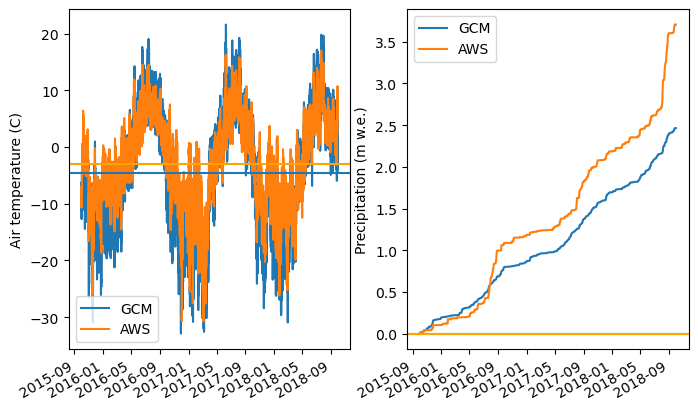

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,5))
ax1.plot(dates,GCM_temp,label='GCM')
ax1.plot(dates,AWS_temp,label='AWS')
ax2.plot(dates,np.cumsum(GCM_precip),label='GCM')
ax2.plot(dates,np.cumsum(AWS_precip),label='AWS')
ax1.axhline(np.mean(GCM_temp))
ax1.axhline(np.mean(AWS_temp),color='orange')
ax2.axhline(np.mean(GCM_precip))
ax2.axhline(np.mean(AWS_precip),color='orange')
ax1.set_ylabel('Air temperature (C)')
ax2.set_ylabel('Precipitation (m w.e.)')
ax1.legend()
ax2.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
df = pd.read_csv('/home/claire/research/climate_data/AWS/Gulkana/LVL2/gulkana1725_hourly_LVL2.csv')
data_start = pd.to_datetime(df.local_time[0])
data_end = pd.to_datetime(df.local_time.to_numpy()[-1])
df = df.set_index(pd.date_range(data_start,data_end,freq='H'))
vars = df.columns
if 'Precip_Stage_Incremental' in vars:
    df.Precip_Weighing_Incremental.fillna(df.Precip_Stage_Incremental*1.48, inplace=True)
AWS_df = df.interpolate('time')